In [123]:
import torch
import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
import matplotlib.pyplot as plt
import torch
import os
import torch.nn as nn


## Loading Models and Testing:

Below are the classes needed for loading the models, make sure to run the cell before trying to evaluate the model

In [124]:
class kryptonite_nn(nn.Module):
    def __init__(self, model_struct):
        super().__init__()
        self.layer1 = nn.Linear(model_struct[0], model_struct[1])
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(model_struct[1], model_struct[2])
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(model_struct[2], model_struct[3])
        self.act3= nn.ReLU()
        self.output = nn.Linear(model_struct[3], model_struct[4])
        self.act_output = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.act_output(self.output(x))
        return x


class KryptoniteModel_n30(nn.Module):
    def __init__(self, structure):
        super().__init__()
        self.layer1 = nn.Linear(structure[0], structure[1])
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(structure[1], structure[2])
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(structure[2], structure[3])
        self.act3 = nn.ReLU()
        self.layer4 = nn.Linear(structure[3], structure[4])
        self.act4 = nn.ReLU()
        self.output = nn.Linear(structure[4], structure[5])
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.act4(self.layer4(x))
        x = self.act_output(self.output(x))
        
        return x


class KryptoniteModel_n12(nn.Module):
    def __init__(self, structure):
        super().__init__()
        self.layer1 = nn.Linear(structure[0], structure[1])
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(structure[1], structure[2])
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(structure[2], structure[3])
        self.act3 = nn.ReLU()
        self.output = nn.Linear(structure[3], structure[4])
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.act_output(self.output(x))
        
        return x

Class to load, evaluate and also predict the hidden labels. The init function takes in n_to_test which can be 9, 12 or 15.
Test accuracy is printed in the eval_model function

In [ ]:
# Data investigation
class KryptoniteNN:
    def __init__(self, n_to_test, device):
        self.batch_size = 100
        self.n_to_test = n_to_test
        self.models_to_load = {9: "saved_models\\model_full_n9_s9-15-10-4-1_100_0.07_500.pth", 
                               12: "saved_models\\model_full_n12_s12-15-10-4-1_100_0.07_500.pth",
                               15: "saved_models\\model_full_n15_s15_15_10_4_1.pth"
        }
        self.model_path = self.models_to_load[n_to_test]
        self.device = device

    def load_model(self):
        self.model = torch.load(self.model_path)

    def load_data(self):
        x_file_path = 'Datasets/kryptonite-' + str(self.n_to_test) + '-X.npy'
        y_file_path = 'Datasets/kryptonite-' + str(self.n_to_test) + '-y.npy'

        x_raw = torch.tensor(np.load(x_file_path), dtype=torch.float32)
        y_raw = torch.tensor(np.load(y_file_path), dtype=torch.float32)

        row_count = x_raw.shape[0]
        print(f"Row count: {row_count}")

        X_train, X_test = torch.tensor_split(
            x_raw,
            [round(row_count * 0.8)],
            dim=0
        )

        y_train, y_test = torch.tensor_split(
            y_raw,
            [round(row_count * 0.8)],
            dim=0
        )

        train_dataset = torch.utils.data.TensorDataset(
            X_train.to(self.device),
            y_train.to(self.device)
        )
        test_dataset = torch.utils.data.TensorDataset(
            X_test.to(self.device),
            y_test.to(self.device)
        )
        
        self.loaders = {
            'train': torch.utils.data.DataLoader(
                train_dataset,
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=0
            ),
            'test': torch.utils.data.DataLoader(
                test_dataset,
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=0
            )
        }
    
    def predict_hidden(self):
        self.model.eval()
        hidden_x_path = "Datasets/hidden-kryptonite-%s-X.npy"%(self.n_to_test)

        x_raw = torch.tensor(np.load(hidden_x_path), dtype=torch.float32)
        x_raw = x_raw.to(self.device)
        model = self.model.to(self.device)
        output = model(x_raw)
        output = output.cpu().detach()

        file_path = "hiddenlabels/y_predicted_%s.npy"%(self.n_to_test)
        np.save(file_path, output)

    def eval_model(self):
        self.model.eval()
        accuracy = np.array([])
        loader_to_use = 'test'
        with torch.no_grad():
            for data in self.loaders[loader_to_use]:
                x, labels = data
                self.model = self.model.to(self.device)
                output = self.model(x)
                output = output.cpu()
                labels = labels.cpu()
                accuracy = np.concatenate((accuracy, torch.eq(torch.flatten(output.round()), labels).numpy()))

        accuracy = accuracy.mean()

        print(f"Test accuracy is: {accuracy * 100:.2f}%")

    def evaluate_model(self):
        self.load_model()
        self.load_data()
        self.eval_model()

n_to_test = 15
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

pipeline = KryptoniteNN(n_to_test, device)
pipeline.evaluate_model()
pipeline.predict_hidden()

Device: cuda
Row count: 30000


C:\Users\Martin\AppData\Local\Temp\ipykernel_12376\1117219241.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model = torch.load(self.model_path)


Test accuracy is: 90.80%
torch.Size([10000, 1])


## Below is the code used to test the Random forest

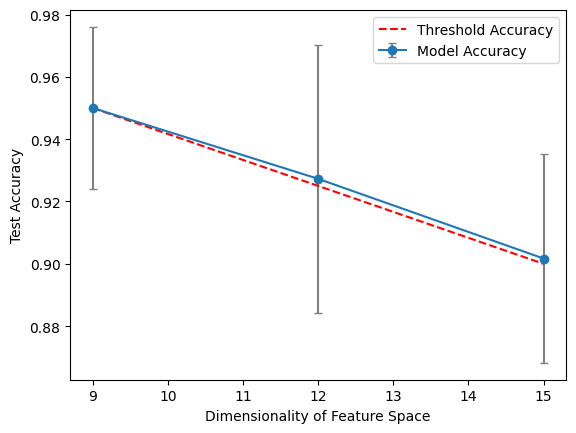

In [ ]:
# 15: 90.80%
# 12: 94.19%
# 9: 95.31%

# n_15 = [0.908, 0.904, 0.880, 0.9135, 0.903]
# n_12 = [0.9285, 0.9419, 0.935, 0.899, 0.932]
# n_9 = [0.954, 0.9581, 0.942, 0.935, 0.961]

# variance = [np.max(n_9) - np.min(n_9), np.max(n_12) - np.min(n_12), np.max(n_15) - np.min(n_15)]

# n_values = [9, 12, 15]
# accuracy = [np.mean(n_9), np.mean(n_12), np.mean(n_15)]
# threshold_acc = [0.95, 0.925, 0.90]

# # plt.plot(n_values, accuracy, marker='o', label="Model Accuracy")
# plt.errorbar(n_values, accuracy, yerr=variance, ecolor="grey", marker="o", capsize=3, label="Model Accuracy")
# plt.plot(n_values, threshold_acc, linestyle='--', color='r', label='Threshold Accuracy')
# plt.xlabel("Dimensionality of Feature Space")
# plt.ylabel("Test Accuracy")
# plt.legend(loc='best')
# plt.savefig("data_imgs/nn.png")

(18000, 9)


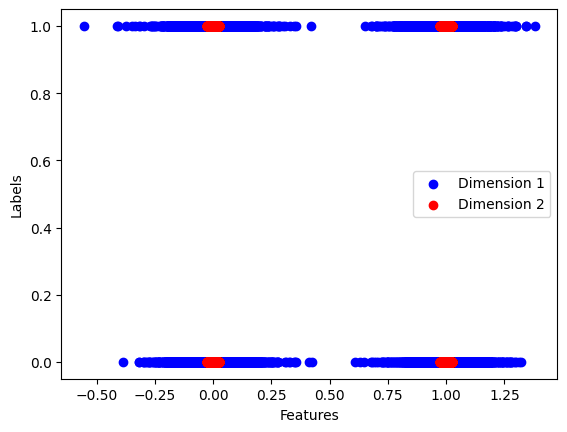

In [122]:
# Data investigation:

def load_data(n):
    X = np.load('Datasets/kryptonite-%s-X.npy'%(n))
    y = np.load('Datasets/kryptonite-%s-y.npy'%(n))

    print(X.shape)
    colors = []
    plt.scatter(X[:, 1], y, color="blue", label="Dimension 1")
    plt.scatter(X[:, 2], y, color="red", label="Dimension 2")
    plt.xlabel("Features")
    plt.ylabel("Labels")
    plt.legend(loc="best")
    plt.savefig("data_final.png")

load_data(9)